## Do stricter gun laws reduce firearm gun deaths?


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Web Scrap the **ranking** of gun laws from a web site listed below:

In [2]:
url = 'https://www.sightmark.com/blogs/news/states-ranked-by-how-strict-their-gun-laws-are?srsltid=AfmBOorw0_lrOckZkxpQII3g4dlJFwRltT0wIrygN2f4-mHymXiA-Qjd'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table')
tbody = soup.find('tbody')
rows = tbody.find_all('tr')

df_list = []
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    df_list.append(cols)

df_rank = pd.DataFrame(df_list)
df_rank.columns = df_rank.iloc[0]
df_rank = df_rank[1:].reset_index(drop=True)

#Convert the Rank and policy number column to numeric:
df_rank['Rank'] = pd.to_numeric(df_rank['Rank'])
df_rank['Number of Gun Safety Policies Adopted'] = pd.to_numeric(df_rank['Number of Gun Safety Policies Adopted'])

df_rank.head()

,Rank,State,Number of Gun Safety Policies Adopted
0,1,California,45
1,2,Illinois,42
2,2,New York,42
3,4,Connecticut,41
4,4,Hawaii,41


To scale the number of policies adopted by each state to a 5 point Likert Scale:

We have to use a min-max formula:
\(x_{scaled}=\frac{(x-x_{min})}{(x_{max}-x_{min})}\cdot (new_{max}-new_{min})+new_{min}\)

In [ ]:
def likert_scale(nums):
    '''We will use min-max normalization to convert the gun law strictness ranking to a 1-5 Likert scale.'''
    
    x_min = min(nums)
    x_max = max(nums)
    
    new_min, new_max = 1, 5
    
    scaled_nums = []
    for num in nums:
        scaled_x = ((num - x_min)/(x_max - x_min)) * (new_max - new_min) + new_min
        scaled_nums.append(round(scaled_x))
    
    return scaled_nums

#Applying to df and make a new column with the Likert Scale of 5 points:
df_rank['likert_scale'] = likert_scale(df_rank['Number of Gun Safety Policies Adopted'])


### Download the CDC firearm mortality dataset via url:

In [4]:
firearm_url = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/cdc_firearm_mortality.csv'

df_firearm = pd.read_csv(firearm_url)
df_firearm.head()


,YEAR,STATE,RATE,DEATHS,URL
0,2023,AL,25.6,"1,292",/nchs/state-stats/states/al.html
1,2023,AK,23.5,176,/nchs/state-stats/states/ak.html
2,2023,AZ,18.5,"1,419",/nchs/state-stats/states/az.html
3,2023,AR,21.9,671,/nchs/state-stats/states/ar.html
4,2023,CA,8.0,"3,209",/nchs/state-stats/states/ca.html


### Webscrap the two letters State name abbreviations so both charts can be combined:

In [5]:
state_url = 'https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html'
state_response = requests.get(state_url)
state_soup = BeautifulSoup(state_response.content, 'html.parser')

state_table = state_soup.find('table')
state_tbody = state_table.find('tbody')
rows = state_tbody.find_all('tr')

state_two_letter_map = {}

for row in rows:
    cols = [td.text.strip() for td in row.find_all('td') if td.text.strip()]
    for i in range(0, len(cols), 2):
        if i +1 < len(cols):
            state_two_letter_map[cols[i]] = cols[i+1]


### Combine all dfs together:

In [6]:
#All the 'STATE' column to df_rank:
df_rank['STATE'] = df_rank['State'].map(state_two_letter_map)

df_final = pd.merge(df_firearm, df_rank, on='STATE', how='left')

#Selecting only the columns we need:
df_final = df_final[['STATE', 'YEAR', 'Number of Gun Safety Policies Adopted', 'likert_scale', 'RATE', 'DEATHS']]

#DC is removed from the dataset since it does not have data from 2014-2021:
df_final = df_final[df_final['STATE'] != 'District of Columbia']

#Checking for Nan values:
df_final.isnull().sum()
df_final.head(10)

,STATE,YEAR,Number of Gun Safety Policies Adopted,likert_scale,RATE,DEATHS
0,AL,2023,11.0,2.0,25.6,"1,292"
1,AK,2023,7.0,1.0,23.5,176
2,AZ,2023,7.0,1.0,18.5,"1,419"
3,AR,2023,4.0,1.0,21.9,671
4,CA,2023,45.0,5.0,8.0,"3,209"
5,CO,2023,32.0,4.0,16.6,"1,019"
6,CT,2023,41.0,5.0,6.2,225
7,DE,2023,28.0,3.0,12.0,124
9,FL,2023,17.0,2.0,13.7,"3,253"
10,GA,2023,4.0,1.0,18.6,"2,070"


### Graph 1:

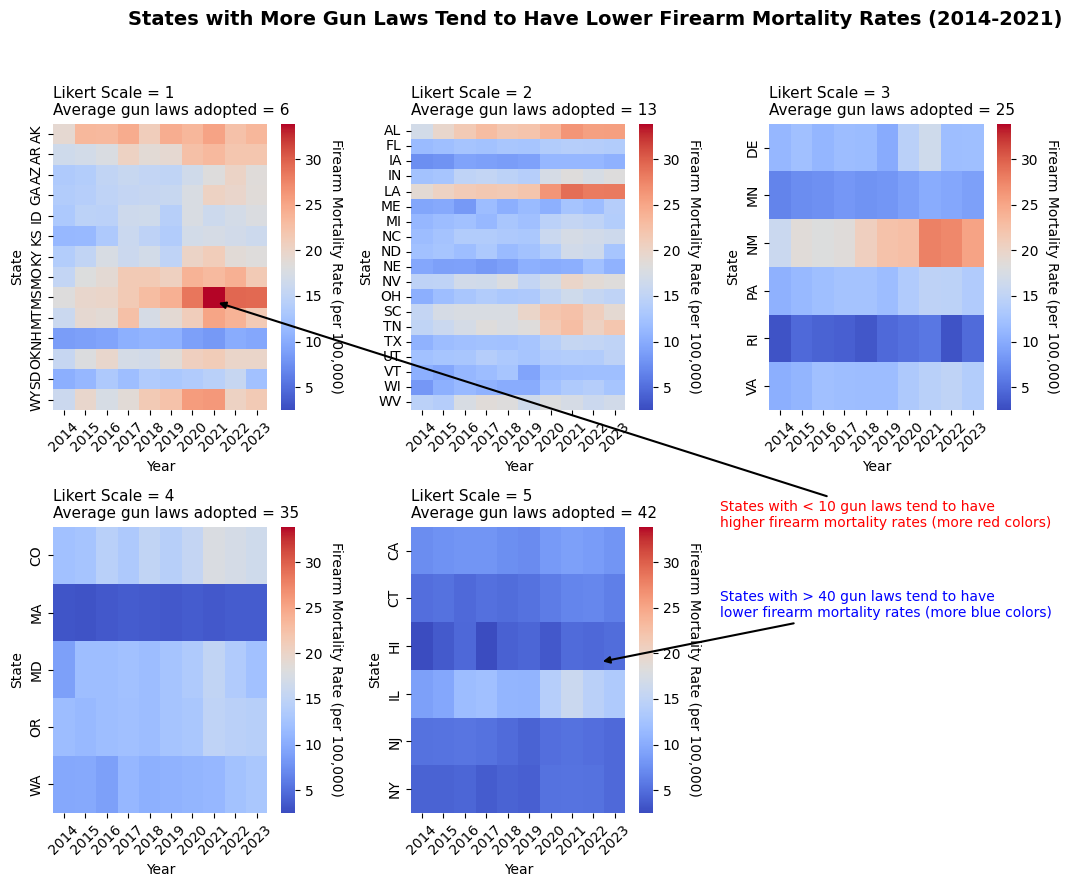

In [95]:
likert_scale = np.sort(df_final['likert_scale'].unique())

n_col = 3
n_row = len(likert_scale) // n_col + 1

fig, axs = plt.subplots(n_row, n_col, figsize=(n_row * 6, n_col * 3), squeeze=False)

v_min = df_final['RATE'].min()
v_max = df_final['RATE'].max()

axs = axs.flatten()

for i, scale in enumerate(likert_scale):
    df_filtered = df_final[df_final['likert_scale']==scale]
    df_pivot = df_filtered.pivot(index='STATE', columns='YEAR', values='RATE')
    
    #Calculate the average gun law adopted for each scale level:
    mean_policies = df_filtered['Number of Gun Safety Policies Adopted'].mean()

    ax = axs[i]

    sns.heatmap(df_pivot,
                cmap='coolwarm',
                annot=False,
                vmax=v_max,
                vmin=v_min,
                ax=ax)
    ax.set_title(f'Likert Scale = {int(scale)}\nAverage gun laws adopted = {mean_policies:.0f}', fontsize=11, loc='left')
    ax.set_xlabel('Year')
    ax.set_ylabel('State')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Firearm Mortality Rate (per 100,000)', rotation=270, labelpad=15)
    
#Removing the empty subplots:
for j in range(len(likert_scale), len(axs)):
    fig.delaxes(axs[j])
    
#Plot asthetics:
plt.suptitle('States with More Gun Laws Tend to Have Lower Firearm Mortality Rates (2014-2021)',  fontweight='bold', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.annotate(
    text='States with < 10 gun laws tend to have\nhigher firearm mortality rates (more red colors)',
    color='red',
    xy=(0.18, 0.65), 
    xytext=(0.6, 0.4), 
    xycoords='figure fraction',
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5))
plt.annotate(
    text='States with > 40 gun laws tend to have\nlower firearm mortality rates (more blue colors)',
    color='blue',
    xy=(0.5, 0.25), 
    xytext=(0.6, 0.3),
    xycoords='figure fraction',
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5)
)
plt.show()

### Graph 2

C:\Users\godly\AppData\Local\Temp\ipykernel_9524\2824056504.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_final,


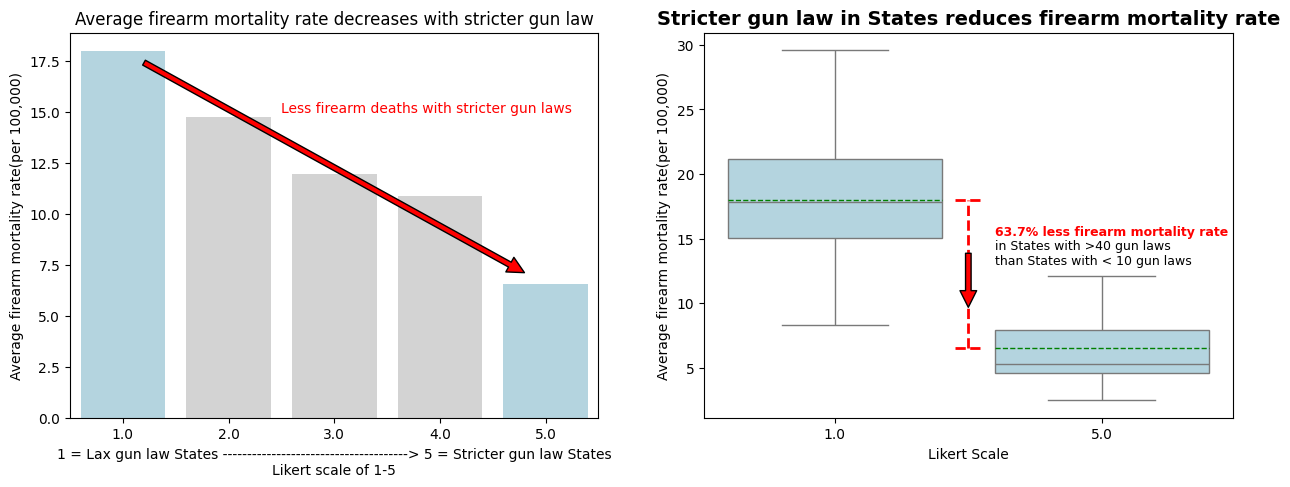

In [96]:
df_min_max = df_final[(df_final['likert_scale'] == 1) | (df_final['likert_scale'] == 5)]

#Plotting the data:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#Plot
palette = {
    '1.0': 'lightblue',
    '2.0': 'lightgray',
    '3.0': 'lightgray',
    '4.0': 'lightgray',
    '5.0': 'lightblue'
}
sns.barplot(df_final,
            x = 'likert_scale',
            y = 'RATE',
            errorbar=None,
            ax = axs[0],
            palette=palette)

# Set title and labels for the first subplot (ax[0])
axs[0].set_title('Average firearm mortality rate decreases with stricter gun law')
axs[0].set_xlabel('1 = Lax gun law States --------------------------------------> 5 = Stricter gun law States\nLikert scale of 1-5')
axs[0].set_ylabel('Average firearm mortality rate(per 100,000)')

#Set arrows:
axs[0].annotate(
    text='',
    xy=(4, df_final[df_final['likert_scale'] == 5]['RATE'].mean()), # Arrow pointing to the mean of likert_scale 5
    xytext=(0, 18), # Text positioned above the mean of likert_scale 1
    arrowprops=dict(facecolor='red', shrink=0.05)
)

axs[0].annotate(text='Less firearm deaths with stricter gun laws',
                xy=(0,0),
                xytext=(1.5, 15),
                color='red')

sns.boxplot(df_min_max,
            x = 'likert_scale',
            y = 'RATE',
            ax = axs[1],
            color='lightblue',
            linewidth=1,
            showmeans=True,
            meanline=True,
            meanprops={'color': 'green', 'linewidth': 1},
            showfliers=False
            )

# Calculate the mean rates for each likert scale (1 and 5)
mean_rate_1 = df_min_max[df_min_max['likert_scale'] == 1]['RATE'].mean()
mean_rate_5 = df_min_max[df_min_max['likert_scale'] == 5]['RATE'].mean()

# Add a vertical line representing the difference between the means
# The x-coordinate is between the two boxplots (0 and 1), so we use 0.5
# The y-coordinates are the calculated means
axs[1].vlines(x=0.5, ymin=mean_rate_5, ymax=mean_rate_1, color='red', linestyle='--', linewidth=2)
axs[1].hlines(xmin=0.45, xmax=0.55, y=mean_rate_5, color='red', linestyle='--', linewidth=2)
axs[1].hlines(xmin=0.45, xmax=0.55, y=mean_rate_1, color='red', linestyle='--', linewidth=2)


# Add an annotation for the percentage difference between the two groups:
axs[1].text(0.6, 15 , f'{(mean_rate_1 - mean_rate_5)/mean_rate_1*100:.1f}% less firearm mortality rate',
         horizontalalignment='left', verticalalignment='bottom', color='red', fontsize=9, fontweight='bold')
axs[1].text(0.6, 12.8 , 'in States with >40 gun laws\nthan States with < 10 gun laws',
         horizontalalignment='left', verticalalignment='bottom', color='black', fontsize=9)

axs[1].annotate(
    text='',
    xy=(0.5,mean_rate_5),
    xytext=(0.5, 17),
    arrowprops=dict(facecolor='red', shrink=0.3)
)


# Set title and labels for the second subplot (ax[1])
axs[1].set_title('Stricter gun law in States reduces firearm mortality rate', fontdict={'fontsize':14, 'fontweight':'bold'})
axs[1].set_xlabel('Likert Scale')
axs[1].set_ylabel('Average firearm mortality rate(per 100,000)')



plt.show()

Summary:

According to the statistic data given by CDC from year 2014 to 2023, the gun law policies adopted by each state were incorporated into this study. The number of gun law adoptation by each state was grouped by a 5 point Likert Scale, where 1 represents the most lax gun law states and 5 the most strict states. The heatmap plot showed that states grouped by the likert scale of 1 to 2 have the most red color, representing the high firearm mortality rate. On the other hand, the states grouped by the Likert Scale of 5 were relatively blue, representing low firearm mortaliy rate. In graph 2, a comparsion between the most lax and the most strict gun law states showed a 63.7% reduction of firearm mortality rate in States with > 40 gun laws adoptation than States with less than 10 adoptations. While there are other facts that might influence the likelihood of firearm mortality rate other than gun law strictness, the conclusion based on these statistics is that states with stricter gunlaw tends to have lower firearm mortality rate than states that have lax gun law. 